In [ ]:
# detrend_smemp_properties.ipynb
# Script to compare the properties derived using Specmath-emp on APF spectra to the properties reported in the Yee et al. 
# 2017 library and calculate the detrending. 
# Last modified 7/2/21 by Anna Zuckerman 
#
# Input: specmatch_results.csv, generated by running smemp_multifile.ipynb on the APF calibration target stars.
# Output:  

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.simbad import Simbad
from scipy.optimize import curve_fit

In [5]:
# find HIP names of each star in order to compare the same stars
def get_HIPname(name):
    if name.startswith('HIP'):
            HIP_name = name
    else:      
        try:
            result_table = Simbad.query_objectids(name)
            alt_names = result_table.to_pandas()
            alt_names = alt_names.iloc[:,0].str.decode('utf-8') #gets rid of weird formatting
            HIP_name = alt_names[alt_names.str.contains("HIP")]
            if len(HIP_name) == 0:
                HIP_name = 'None'
                print(name + ' has no HIP name in SIMBAD') #this should never occur since only using stars with HIP names for finding overlap between apf and Yee
            elif len(HIP_name) == 1:
                HIP_name = str(HIP_name.iloc[0]) # makes it a string instead of dataframe with one cell  
            else:
                print('more than one HIP name found for ' + name)
        except AttributeError:
            HIP_name = 'None'
            print(name + ': SIMBAD search error (likely \'No known catalog could be found\' or \'this identifier has an incorrect format for catalog\'') # should not happen
    return HIP_name


In [6]:
# read in files
apf_data = pd.read_csv('specmatch_results.csv') 
yee_data = pd.read_csv('yee_library_full.csv')

# process names in file so be searchable by Simbad (move this logic to inside get_HIPname loop to speed up!)
for row in range(len(apf_data)):
    name = apf_data.iloc[row,0]
    if name[0].isdigit():
        apf_data.iloc[row,0] = 'HD' + name
    elif name.startswith('K0'):
        apf_data.iloc[row,0] = 'KOI-' + name[1:]
    elif name.startswith('EPIC-'):
        apf_data.iloc[row,0] = 'EPIC' + name[5:]

# sort by HIP name of stars for easy comparison
apf_HIP = apf_data
for row in range(len(apf_data)):
    apf_HIP.iloc[row,0] = get_HIPname(apf_data.iloc[row,0]).replace(' ','')
apf_HIP.rename(columns = {'apf_name':'HIP_name'}, inplace = True)
apf_sorted = apf_HIP.sort_values(by=['HIP_name'])

yee_HIP = yee_data
drop_rows = []
for row in range(len(yee_data)):
    yee_HIP.iloc[row,0] = get_HIPname(yee_data.iloc[row,0]).replace(' ','')  
    if not(apf_sorted["HIP_name"].str.contains(yee_HIP.iloc[row,0]).any()):
        drop_rows = drop_rows + [row]
yee_HIP = yee_HIP.drop(drop_rows)
yee_HIP.rename(columns = {'Name':'HIP_name'}, inplace = True)
yee_sorted = yee_HIP.sort_values(by=['HIP_name'])


/opt/conda/lib/python3.7/site-packages/astroquery-0.4.1.dev0-py3.7.egg/astroquery/simbad/core.py:138: UserWarning: Warning: The script line number 2 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : HD 124257A
  (error.line, error.msg))


HD 124257A  : SIMBAD search error (likely 'No known catalog could be found' or 'this identifier has an incorrect format for catalog'
HD 3684      has no HIP name in SIMBAD
KOI-1925     has no HIP name in SIMBAD
KOI-1612     has no HIP name in SIMBAD
KIC 10018963 has no HIP name in SIMBAD
KIC 10355856 has no HIP name in SIMBAD
KIC 10516096 has no HIP name in SIMBAD
KIC 10644253 has no HIP name in SIMBAD
KIC 10709834 has no HIP name in SIMBAD
KIC 11026764 has no HIP name in SIMBAD
KIC 11137075 has no HIP name in SIMBAD
KIC 11244118 has no HIP name in SIMBAD
KIC 11414712 has no HIP name in SIMBAD
KIC 11717120 has no HIP name in SIMBAD
KIC 12009504 has no HIP name in SIMBAD
KIC 1435467  has no HIP name in SIMBAD
KIC 3427720  has no HIP name in SIMBAD
KIC 3656476  has no HIP name in SIMBAD
KIC 5021689  has no HIP name in SIMBAD
KIC 5184732  has no HIP name in SIMBAD
KIC 5596656  has no HIP name in SIMBAD
KIC 5773345  has no HIP name in SIMBAD
KIC 5955122  has no HIP name in SIMBAD
KIC 61160

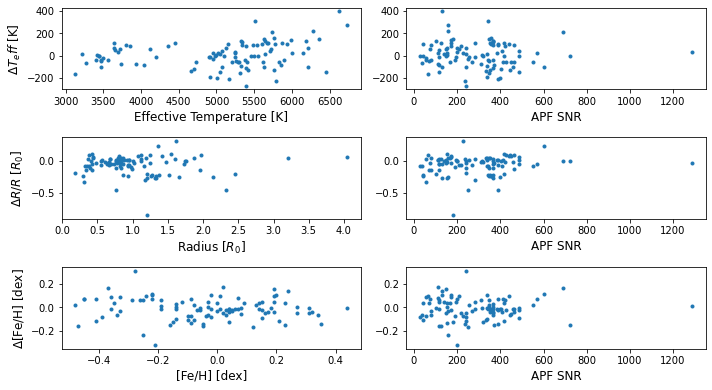

In [7]:
# plot certain properties to compare

SNR_results = pd.read_csv('SNR_results.csv')
SNR_results_sorted = SNR_results.sort_values(by=['HIP_NAME'])
apf_SNR = SNR_results_sorted['SNR']
 
apf_Teff = apf_sorted.iloc[:,1].to_numpy() 
yee_Teff = yee_sorted.iloc[:,1].to_numpy()
apf_R = apf_sorted.iloc[:,3].to_numpy()
yee_R = yee_sorted.iloc[:,3].to_numpy()
apf_feh = apf_sorted.iloc[:,7].to_numpy()
yee_feh = yee_sorted.iloc[:,7].to_numpy()

# remove  38th star (lowest SNR, outlier in being very far from Yee values)
# [NO LONGER RELEVENT]
#apf_Teff = np.append(apf_Teff[0:38],apf_Teff[39:])
#yee_Teff = np.append(yee_Teff[0:38],yee_Teff[39:])
#apf_R = np.append(apf_R[0:38],apf_R[39:])
#yee_R = np.append(yee_R[0:38],yee_R[39:])
#apf_feh = np.append(apf_feh[0:38],apf_feh[39:])
#yee_feh = np.append(yee_feh[0:38],yee_feh[39:])
#apf_SNR = np.append(apf_SNR[0:38],apf_SNR[39:])

# plot difference between APF Specmatch and Yee properties, vs Yee Properties
fig, axs = plt.subplots(3, 2, figsize = (10,6)) 
axs[0,0].plot(yee_Teff,yee_Teff-apf_Teff,'.') 
axs[0,0].set_xlabel('Effective Temperature [K]',fontsize = 12)
axs[0,0].set_ylabel('$\Delta T_eff$ [K]',fontsize = 12)
axs[1,0].plot(yee_R, (yee_R-apf_R)/yee_R,'.')
axs[1,0].set_xlabel('Radius [$R_0$]',fontsize = 12)
axs[1,0].set_ylabel('$\Delta R/ R$ [$R_0$]',fontsize = 12)
axs[2,0].plot(yee_feh, yee_feh-apf_feh,'.')
axs[2,0].set_xlabel('[Fe/H] [dex]',fontsize = 12)
axs[2,0].set_ylabel('$\Delta$[Fe/H] [dex]',fontsize = 12)
#fig.suptitle('APF Specmatch-emp derived properties vs properties reported by Yee et al.')
#fig.tight_layout(pad=1.0)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('APF_Yee_comparison.png')

# plot difference between APF Specmatch and Yee properties, vs APF SNR
#fig, axs = plt.subplots(3, 1, figsize = (6,6)) 
axs[0,1].plot(apf_SNR,yee_Teff-apf_Teff,'.') #Is this right to use Yee as the x-axis, 'correct' T value?
axs[0,1].set_xlabel('APF SNR',fontsize = 12)
#axs[0,1].set_ylabel('$\Delta T_eff$ [K]',fontsize = 14)
axs[1,1].plot(apf_SNR, (yee_R-apf_R)/yee_R,'.') # why normalize to R?
axs[1,1].set_xlabel('APF SNR',fontsize = 12)
#axs[1,1].set_ylabel('$\Delta R/ R$ [$R_0$]',fontsize = 14)
axs[2,1].plot(apf_SNR, yee_feh-apf_feh,'.')
axs[2,1].set_xlabel('APF SNR',fontsize = 12)
#axs[2,1].set_ylabel('$\Delta$[Fe/H] [dex]',fontsize = 14)
#fig.suptitle('Difference APF to catalog values vs SNR of APF data')
#fig.tight_layout(pad=1.0)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('APF_Yee_comparison_SNR.png')

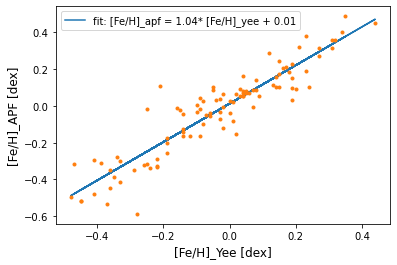

In [23]:
# fit trends as described in Yee et al. 2017

# for [Fe/H] fit a linear trend
def linear_func(x,a,b):
    return a*x + b

plt.plot(yee_feh, linear_func(yee_feh, *popt), label = 'fit: [Fe/H]_apf = ' + str(np.round(popt[0],2)) + '* [Fe/H]_yee + ' + str(np.round(popt[1],2)))
popt, pcov = curve_fit(linear_func, yee_feh, apf_feh)
plt.plot(yee_feh, apf_feh,'.')
plt.xlabel('[Fe/H]_Yee [dex]',fontsize = 12)
plt.ylabel('[Fe/H]_APF [dex]',fontsize = 12)
plt.legend()

In [ ]:
#  for checking which stars have the greatest differences
def check_differ():
    idxs = []
    for idx in range(len(yee_R)):
        if abs(apf_R[idx] - yee_R[idx])/yee_R[idx] > 1.0: # can change to any useful test
            idxs = idxs + [idx]
    diff = (apf_R - yee_R)/yee_R
    return idxs
check_differ()

In [30]:
# calculate RMS for new results (FIRST RUN ABOVE ON THE DESIRED RESULTS )
def calc_RMS():
    diff = (apf_R - yee_R)/yee_R
    rms_R_new = np.sqrt(np.mean(diff**2)) 
    print('rms_R = ' + str(rms_R_new))

    diff =  (apf_Teff - yee_Teff)
    rms_T_new = np.sqrt(np.mean(diff**2))
    print('rms_Teff = ' + str(rms_T_new))

    diff =  (apf_feh - yee_feh)
    rms_feh_new = np.sqrt(np.mean(diff**2)) 
    print('rms_feh = ' + str(rms_feh_new))

calc_RMS()

rms_R = 0.160491926348313
rms_Teff = 114.33181526280048
rms_feh = 0.09103829027958348


In [33]:
def calc_RMS_at_divisions():
    # To get at division in deltas at T ~ 4500K
    apf_Teff_1 = apf_Teff[yee_Teff < 4500]
    yee_Teff_1 = yee_Teff[yee_Teff < 4500]
    apf_Teff_2 = apf_Teff[yee_Teff >= 4500]
    yee_Teff_2 = yee_Teff[yee_Teff >= 4500]

    apf_R_1 = apf_R[yee_Teff < 4500]
    yee_R_1 = yee_R[yee_Teff < 4500]
    apf_R_2 = apf_R[yee_Teff >= 4500]
    yee_R_2 = yee_R[yee_Teff >= 4500]

    apf_feh_1 = apf_feh[yee_Teff < 4500]
    yee_feh_1 = yee_feh[yee_Teff < 4500]
    apf_feh_2 = apf_feh[yee_Teff >= 4500]
    yee_feh_2 = yee_feh[yee_Teff >= 4500]

    diff = (apf_R_1 - yee_R_1)/yee_R_1
    rms_R_new = np.sqrt(np.mean(diff**2)) 
    print('rms_R for T<4500 = ' + str(rms_R_new))

    diff = (apf_R_2 - yee_R_2)/yee_R_2
    rms_R_new = np.sqrt(np.mean(diff**2)) 
    print('rms_R for T>4500 = ' + str(rms_R_new))

    diff =  (apf_Teff_1 - yee_Teff_1)
    rms_T_new = np.sqrt(np.mean(diff**2))
    print('rms_Teff for T<4500 = ' + str(rms_T_new))

    diff =  (apf_Teff_2 - yee_Teff_2)
    rms_T_new = np.sqrt(np.mean(diff**2))
    print('rms_Teff for T>4500 = ' + str(rms_T_new))

    diff =  (apf_feh_1 - yee_feh_1)
    rms_feh_new = np.sqrt(np.mean(diff**2)) 
    print('rms_feh for T<4500= ' + str(rms_feh_new))

    diff =  (apf_feh_2 - yee_feh_2)
    rms_feh_new = np.sqrt(np.mean(diff**2)) 
    print('rms_feh for T>4500= ' + str(rms_feh_new))
    
    # To get at division in deltas at R ~ 1.0 Ro
    apf_Teff_1 = apf_Teff[yee_R < 1.0]
    yee_Teff_1 = yee_Teff[yee_R < 1.0]
    apf_Teff_2 = apf_Teff[yee_R > 1.0]
    yee_Teff_2 = yee_Teff[yee_R > 1.0]

    apf_R_1 = apf_R[yee_R < 1.0]
    yee_R_1 = yee_R[yee_R < 1.0]
    apf_R_2 = apf_R[yee_R > 1.0]
    yee_R_2 = yee_R[yee_R > 1.0]

    apf_feh_1 = apf_feh[yee_R < 1.0]
    yee_feh_1 = yee_feh[yee_R < 1.0]
    apf_feh_2 = apf_feh[yee_R > 1.0]
    yee_feh_2 = yee_feh[yee_R > 1.0]

    diff = (apf_R_1 - yee_R_1)/yee_R_1
    rms_R_new = np.sqrt(np.mean(diff**2)) 
    print('rms_R for R<1.0 = ' + str(rms_R_new))

    diff = (apf_R_2 - yee_R_2)/yee_R_2
    rms_R_new = np.sqrt(np.mean(diff**2)) 
    print('rms_R for R>1.0 = ' + str(rms_R_new))

    diff =  (apf_Teff_1 - yee_Teff_1)
    rms_T_new = np.sqrt(np.mean(diff**2))
    print('rms_Teff for R<1.0 = ' + str(rms_T_new))

    diff =  (apf_Teff_2 - yee_Teff_2)
    rms_T_new = np.sqrt(np.mean(diff**2))
    print('rms_Teff for R>1.0 = ' + str(rms_T_new))

    diff =  (apf_feh_1 - yee_feh_1)
    rms_feh_new = np.sqrt(np.mean(diff**2)) 
    print('rms_feh for R<1.0 = ' + str(rms_feh_new))

    diff =  (apf_feh_2 - yee_feh_2)
    rms_feh_new = np.sqrt(np.mean(diff**2)) 
    print('rms_feh for R>1.0 = ' + str(rms_feh_new))

calc_RMS_at_divisions()

rms_R for T<4500 = 0.10735169784147
rms_R for T>4500 = 0.1751909220614897
rms_Teff for T<4500 = 71.48467889345241
rms_Teff for T>4500 = 125.82456675233713
rms_feh for T<4500= 0.11078461431638767
rms_feh for T>4500= 0.08310483339333119
rms_R for R<1.0 = 0.10519438646739061
rms_R for R>1.0 = 0.22161645350948111
rms_Teff for R<1.0 = 89.10930622365598
rms_Teff for R>1.0 = 145.70246446176117
rms_feh for R<1.0 = 0.08319089978147619
rms_feh for R>1.0 = 0.10228166239135177


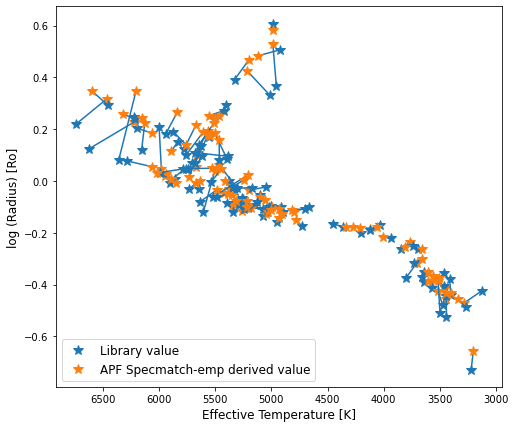

In [109]:
# visualize the difference betwenn library and derived values
all_yee_properties = pd.read_csv('yee_library_full.csv')
all_yee_Teff = all_yee_properties.iloc[:,1]
all_yee_R = all_yee_properties.iloc[:,3] 
plt.figure(figsize = (8,7));
for star in range(len(yee_Teff)):    
    if star == 1:
        labels = ['_nolegend_', 'Library value', 'APF Specmatch-emp derived value']
    else:
        labels = ['_nolegend_', '_nolegend_','_nolegend_']
    plt.plot([yee_Teff[star], apf_Teff[star]], [np.log10(yee_R[star]), np.log10(apf_R[star])],  c='C0',  label=labels[0])
    plt.plot(yee_Teff[star], np.log10(yee_R[star]),'*', markersize = 10, c = 'C0', label = labels[1]) # Just the ones we used
    plt.plot(apf_Teff[star], np.log10(apf_R[star]),'*', markersize = 10, c = 'C1', label = labels[2]) # just the ones we used
plt.gca().invert_xaxis()
plt.ylabel('log (Radius) [Ro]', fontsize = 12)
plt.xlabel('Effective Temperature [K]', fontsize = 12)
plt.legend(fontsize = 12)
plt.savefig('Comparison_visual.png')

Text(0.5, 0, 'Effective Temperature [K]')

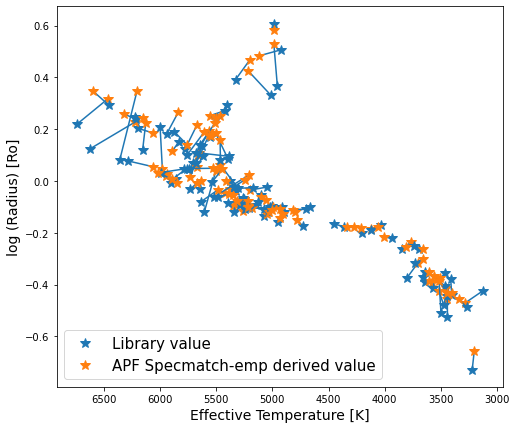

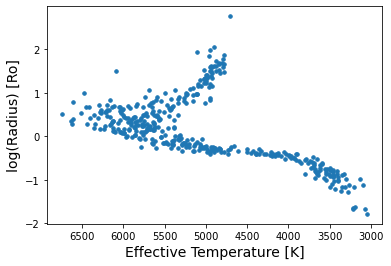

In [100]:
all_yee_properties = pd.read_csv('yee_library_full.csv')
all_yee_Teff = all_yee_properties.iloc[:,1]
all_yee_R = all_yee_properties.iloc[:,3] 
plt.figure(figsize = (8,7));
for star in range(len(yee_Teff)):    
    if star == 1:
        labels = ['_nolegend_', 'Library value', 'APF Specmatch-emp derived value']
    else:
        labels = ['_nolegend_', '_nolegend_','_nolegend_']
    plt.plot([yee_Teff[star], apf_Teff[star]], [np.log10(yee_R[star]), np.log10(apf_R[star])],  c='C0',  label=labels[0])
    plt.plot(yee_Teff[star], np.log10(yee_R[star]),'*', markersize = 10, c = 'C0', label = labels[1]) # Just the ones we used
    plt.plot(apf_Teff[star], np.log10(apf_R[star]),'*', markersize = 10, c = 'C1', label = labels[2]) # just the ones we used
plt.gca().invert_xaxis()
plt.ylabel('log (Radius) [Ro]', fontsize = 14)
plt.xlabel('Effective Temperature [K]', fontsize = 14)
plt.legend(fontsize = 15)

plt.figure();plt.plot(all_yee_Teff,np.log(all_yee_R),'.', markersize = 7, label = "library stars")
plt.gca().invert_xaxis()
plt.ylabel('log(Radius) [Ro]', fontsize = 14)
plt.xlabel('Effective Temperature [K]', fontsize = 14)
#plt.legend(fontsize = 15)